In [1]:
# this notebook preprocesses the data to feed it to a forcasting model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("../data/COVID19_timeseries.csv")

In [4]:
data.head()

,country,date,infections,Lat,Long,deaths,recovered,Continent,bed_occupancy,ICU_beds,Population,population_world,age_0_to_64,age_15_to_64,age_over_65,month,day
0,Australia,1/24/20,0,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,24.0
1,Australia,1/25/20,0,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,25.0
2,Australia,1/26/20,4,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,26.0
3,Australia,1/27/20,5,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,27.0
4,Australia,1/28/20,5,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,28.0


In [5]:
data.shape

(1887, 17)

In [6]:
# add country as index
data = data.set_index('country')

In [7]:
# dummy encode the 'Continent' column
data = pd.concat([data, pd.get_dummies(data['Continent'])], axis=1).drop('Continent', axis=1)

In [8]:
# drop the date and population column 
dates = data.date
data = data.drop(['date', 'Population', 'deaths', 'recovered', 'month', 'day'], axis=1)

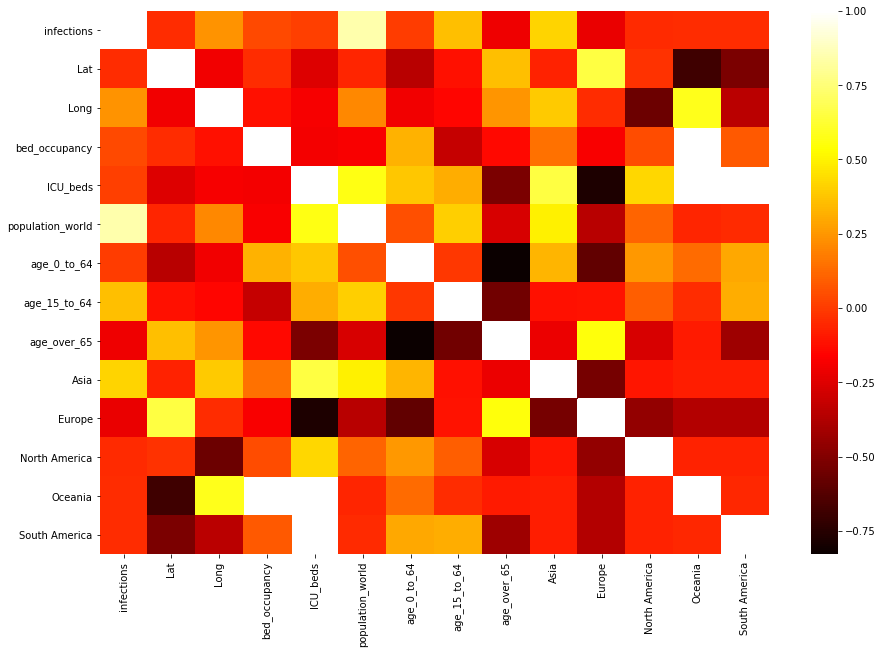

In [9]:
# visualize correlations between columns
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 10)
sns.heatmap(data.corr(), cmap='hot', ax=ax)

In [10]:
# bed_occupancy and ICU_beds contain NaNs values
# KNN impute both columns

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)

In [11]:
imputer.fit(data)

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=3, weights='uniform')

In [12]:
data = pd.DataFrame(imputer.transform(data), columns=data.columns, index=data.index)

In [13]:
# set country as index
data.head()

,infections,Lat,Long,bed_occupancy,ICU_beds,population_world,age_0_to_64,age_15_to_64,age_over_65,Asia,Europe,North America,Oceania,South America
country,,,,,,,,,,,,,,
Australia,0.0,-24.502867,141.055589,0.755,46.0,0.0033,0.19,0.655,0.155,0.0,0.0,0.0,1.0,0.0
Australia,0.0,-24.502867,141.055589,0.755,46.0,0.0033,0.19,0.655,0.155,0.0,0.0,0.0,1.0,0.0
Australia,4.0,-24.502867,141.055589,0.755,46.0,0.0033,0.19,0.655,0.155,0.0,0.0,0.0,1.0,0.0
Australia,5.0,-24.502867,141.055589,0.755,46.0,0.0033,0.19,0.655,0.155,0.0,0.0,0.0,1.0,0.0
Australia,5.0,-24.502867,141.055589,0.755,46.0,0.0033,0.19,0.655,0.155,0.0,0.0,0.0,1.0,0.0


In [14]:
# use Netherlands as test data series and Belgium as validation series
data_nl = data[data.index == "Netherlands"]
data_bel = data[data.index == "Belgium"]

In [15]:
# drop test and validation data from train data
data = data.drop(['Netherlands', 'Belgium'])

In [16]:
data_nl.head()

,infections,Lat,Long,bed_occupancy,ICU_beds,population_world,age_0_to_64,age_15_to_64,age_over_65,Asia,Europe,North America,Oceania,South America
country,,,,,,,,,,,,,,
Netherlands,0.0,52.1326,5.2913,0.654,6.4,0.00224,0.164,0.648,0.188,0.0,1.0,0.0,0.0,0.0
Netherlands,0.0,52.1326,5.2913,0.654,6.4,0.00224,0.164,0.648,0.188,0.0,1.0,0.0,0.0,0.0
Netherlands,0.0,52.1326,5.2913,0.654,6.4,0.00224,0.164,0.648,0.188,0.0,1.0,0.0,0.0,0.0
Netherlands,0.0,52.1326,5.2913,0.654,6.4,0.00224,0.164,0.648,0.188,0.0,1.0,0.0,0.0,0.0
Netherlands,0.0,52.1326,5.2913,0.654,6.4,0.00224,0.164,0.648,0.188,0.0,1.0,0.0,0.0,0.0


In [17]:
n_countries = 35
n_timesteps = 51
n_features = len(data.columns)

In [18]:
data.columns[13]

'South America'

In [19]:
# create the labels by shifting the 'infections' column to the left
# make sure to create labels before scaling the data!
y_train = data.values[:, 0].copy()
y_val = data_bel.values[:, 0].copy()
y_test = data_nl.values[:, 0].copy()

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_partially(data, columns_to_scale, columns_to_skip, scaler):
    data_to_scale = data[columns_to_scale]
    data_to_skip = data[columns_to_skip]
    
    data_to_scale = scaler.transform(data_to_scale)
    data = np.concatenate([data_to_scale, data_to_skip], axis=1)
    
    return data
    
def fit_partially(data, columns_to_scale, columns_to_skip, scaler):   
    data_to_scale = data[columns_to_scale]
    data_to_skip = data[columns_to_skip]  
    scaler.fit(data_to_scale)
    
    return scaler
    
    

In [21]:
# create scaler and fit on training data
#scaler = StandardScaler()
scaler = MinMaxScaler()


In [22]:
data.columns

Index(['infections', 'Lat', 'Long', 'bed_occupancy', 'ICU_beds',
       'population_world', 'age_0_to_64', 'age_15_to_64', 'age_over_65',
       'Asia', 'Europe', 'North America', 'Oceania', 'South America'],
      dtype='object')

In [23]:
columns_to_scale = ['Lat', 
                   'Long'
                   ]

columns_to_skip=[#'month',
                 # 'day',
                  'infections',
                  #'deaths',
                  #'recovered',
                   'bed_occupancy',
                   'ICU_beds',
                   'population_world',
                   'age_0_to_64',
                   'age_15_to_64', 
                   'age_over_65',
                   'Asia',
                   'Europe',
                   'North America',
                   'Oceania',
                   'South America']

In [24]:
# fit the scaler
scaler = fit_partially(data, 
                       columns_to_scale=columns_to_scale,
                       columns_to_skip=columns_to_skip,
                       scaler=scaler)                                      

In [25]:
# scale all data
data = scale_partially(data, 
                       columns_to_scale=columns_to_scale,
                       columns_to_skip=columns_to_skip,
                       scaler=scaler)   

data_bel = scale_partially(data_bel, 
                       columns_to_scale=columns_to_scale,
                       columns_to_skip=columns_to_skip,
                       scaler=scaler)   

data_nl = scale_partially(data_nl, 
                       columns_to_scale=columns_to_scale,
                       columns_to_skip=columns_to_skip,
                       scaler=scaler)     

In [26]:
# add original infections back to data
#data[:, 0] = y_train
#data_bel[:, 0] = y_val
#data_nl[:, 0] = y_test

In [27]:
#data = data.values
#data_bel = data_bel.values
#data_nl = data_nl.values

In [28]:
# reshape data to appropriate 3D timeseries data
x_train = np.reshape(data, (n_countries, n_timesteps, n_features))

In [29]:
x_val = np.reshape(data_bel, (1, n_timesteps, n_features))
x_test = np.reshape(data_nl, (1, n_timesteps, n_features))

In [30]:
# reshape labels according to the data
y_train = np.reshape(y_train, (x_train.shape[0], x_train.shape[1], 1))
y_val = np.reshape(y_val, (x_val.shape[0], x_val.shape[1], 1))
y_test = np.reshape(y_test, (x_test.shape[0], x_test.shape[1], 1))

In [31]:
# to shift to left, remove first element
y_train = y_train[:, 1:]
y_val = y_val[:, 1:]
y_test = y_test[:, 1:]

# add outer dimension to match dimensionality of data
#y_train = np.expand_dims(y_train, axis=2)
#y_val = np.expand_dims(y_val, axis=2)
#y_test = np.expand_dims(y_test, axis=2)

In [32]:
# shift data to right by removing final timestep
x_train = x_train[:, :-1]
x_val = x_val[:, :-1]
x_test = x_test[:, :-1]

In [33]:
x_train.shape, x_val.shape, x_test.shape

((35, 50, 14), (1, 50, 14), (1, 50, 14))

In [34]:
y_train.shape, y_val.shape, y_test.shape

((35, 50, 1), (1, 50, 1), (1, 50, 1))

In [35]:
import tensorflow.keras as keras
# build and return a simple LSTM autoencoder in Keras
def build_model(n_features, embedding_size, learning_rate):
    # the input to the LSTM is a mini-batch (None) of a certain sequence length (50) of n_features (18)
    input_layer = keras.layers.Input(shape=(None, n_features))
    # return sequence of LSTM states
    hidden_sequences = keras.layers.LSTM(units=embedding_size, return_sequences=True)(input_layer)
    #hidden_sequences = keras.layers.SimpleRNN(units=embedding_size, return_sequences=True)(input_layer)
    
    # Output layer is 1 neuron for regression
    output_layer = keras.layers.Dense(units=1, activation='linear')(hidden_sequences)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss="MSE")
    
    return model

d:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1ty

In [36]:
model = build_model(n_features, embedding_size=250, learning_rate=0.02)

In [37]:
model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=n_countries, epochs=10000)

Train on 35 samples, validate on 1 samples
Epoch 1/10000
35/35 [==============================] - 5s 149ms/step - loss: 114210784.0000 - val_loss: 23559.8516
Epoch 2/10000
35/35 [==============================] - 0s 7ms/step - loss: 114202040.0000 - val_loss: 23100.3516
Epoch 3/10000
35/35 [==============================] - 0s 7ms/step - loss: 114189984.0000 - val_loss: 22721.9004
Epoch 4/10000
35/35 [==============================] - 0s 8ms/step - loss: 114181552.0000 - val_loss: 22393.1699
Epoch 5/10000
35/35 [==============================] - 0s 7ms/step - loss: 114172376.0000 - val_loss: 22133.2598
Epoch 6/10000
35/35 [==============================] - 0s 7ms/step - loss: 114159312.0000 - val_loss: 21871.6270
Epoch 7/10000
35/35 [==============================] - 0s 7ms/step - loss: 114150824.0000 - val_loss: 21613.2559
Epoch 8/10000
35/35 [==============================] - 0s 6ms/step - loss: 114143872.0000 - val_loss: 21359.3398
Epoch 9/10000
35/35 [==============================

Epoch 73/10000
35/35 [==============================] - 0s 6ms/step - loss: 113547184.0000 - val_loss: 7565.8608
Epoch 74/10000
35/35 [==============================] - 0s 6ms/step - loss: 113538168.0000 - val_loss: 7442.0317
Epoch 75/10000
35/35 [==============================] - 0s 6ms/step - loss: 113529128.0000 - val_loss: 7316.1880
Epoch 76/10000
35/35 [==============================] - 0s 7ms/step - loss: 113520096.0000 - val_loss: 7201.9092
Epoch 77/10000
35/35 [==============================] - 0s 7ms/step - loss: 113511160.0000 - val_loss: 7057.9282
Epoch 78/10000
35/35 [==============================] - 0s 7ms/step - loss: 113502080.0000 - val_loss: 6943.1074
Epoch 79/10000
35/35 [==============================] - 0s 8ms/step - loss: 113493104.0000 - val_loss: 6835.3389
Epoch 80/10000
35/35 [==============================] - 0s 7ms/step - loss: 113484096.0000 - val_loss: 6742.2393
Epoch 81/10000
35/35 [==============================] - 0s 8ms/step - loss: 113475112.0000 - val

35/35 [==============================] - 0s 6ms/step - loss: 112909208.0000 - val_loss: 2396.2219
Epoch 146/10000
35/35 [==============================] - 0s 6ms/step - loss: 112900472.0000 - val_loss: 2371.1455
Epoch 147/10000
35/35 [==============================] - 0s 7ms/step - loss: 112891728.0000 - val_loss: 2298.6548
Epoch 148/10000
35/35 [==============================] - 0s 7ms/step - loss: 112883024.0000 - val_loss: 2385.4131
Epoch 149/10000
35/35 [==============================] - 0s 7ms/step - loss: 112883400.0000 - val_loss: 2217.9421
Epoch 150/10000
35/35 [==============================] - 0s 8ms/step - loss: 112865600.0000 - val_loss: 2130.1323
Epoch 151/10000
35/35 [==============================] - 0s 8ms/step - loss: 112856880.0000 - val_loss: 2304.8030
Epoch 152/10000
35/35 [==============================] - 0s 7ms/step - loss: 112848176.0000 - val_loss: 2060.6631
Epoch 153/10000
35/35 [==============================] - 0s 7ms/step - loss: 112839448.0000 - val_loss: 

KeyboardInterrupt: 

In [38]:
preds_nl = np.squeeze(model.predict(x_test))

In [39]:
# plot  predictions vs actual infections
def plot_preds_vs_actual(dates, predictions, labels):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,5)
    plt.xticks(ticks=[0, 50], labels=[dates.unique()[0], dates.unique()[50]])
    plt.ylabel('Infections')
    plt.xlabel('date')
    plt.title('Predicted infections versus actual infections in the Netherlands')
    sns.lineplot(data=np.squeeze(labels), ax=ax)
    sns.lineplot(data=predictions, ax=ax)
    plt.legend(['Actual', 'Predictions']) 

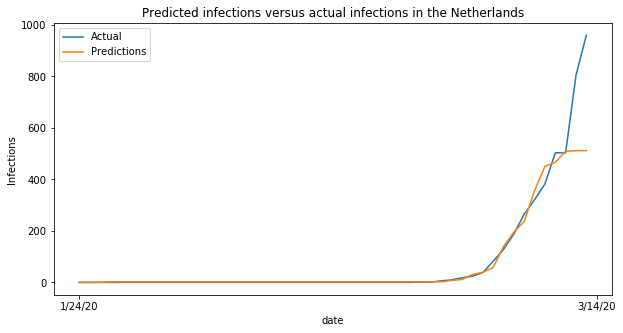

In [40]:
# show predictions vs actual infections
plot_preds_vs_actual(dates, preds_nl, y_test)

In [60]:
# predict until certain point, then add predictions to data to keep forecasting
def forecast(model, data, days_ahead):
    idx_infected = 0
    idx_day = 3
    idx_month = 2
    
    # do initial prediction
    preds = model.predict(data)
     
    for i in range(days_ahead):
        # take final prediction
        pred_new = preds[:, -1]
        # copy timeseries timestep 
        timestep_new = data[0, -1].copy()
        # increment day and month, or reset if needed
        """if(timestep_new[idx_day] <= 30):
            timestep_new[idx_day] += 1
        else:
             timestep_new[idx_day] = 1
             timestep_new[idx_month] += 1
   
        """
            
        # add predicted infections as actual infections to new timestep
        timestep_new[idx_infected] = pred_new
        # append new timestep to time series
        timestep_new = np.expand_dims(timestep_new, axis=[0,1]) 
        data = np.append(data, timestep_new, axis=1)
        #data = data[:, 1:]
        
        preds = model.predict(data)
        
    #print(np.squeeze(preds))
    return np.squeeze(preds)

In [63]:
preds = forecast(model, x_test.copy(), 10)
preds.shape

(60,)

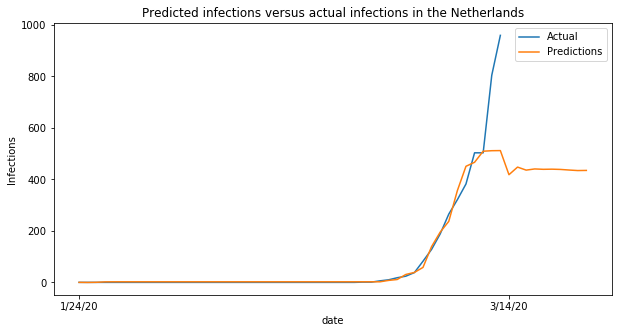

In [64]:
plot_preds_vs_actual(dates=dates, predictions=preds, labels=y_test)